Functions

In [1]:
def visualize_meshgrid(x, y, target_func, title=None):
    X = np.array(np.meshgrid(x, y))
    Z = target_func(X)
    plt.pcolormesh(x,y,Z, cmap="inferno")
    plt.colorbar()
    if title:
        plt.title(title)
    plt.show()


def generate_sample(n, n_dims, lower, upper, target_func, noise_scale=0, random_state=42):
    """
    Generates data sample.
    """
    rs = np.random.RandomState(random_state)
    X = rs.rand(n_dims,n)
    for i in range(n_dims):
        X[i] = X[i]*(upper[i]-lower[i]) + lower[i]
    y = target_func(X)
    y += rs.normal(0, noise_scale, size=y.shape)
    
    return (X,y)

Generate data sample

In [2]:
import numpy as np

target_func = lambda X: (20 + X**2 - 10 * np.cos(2*np.pi*X)).sum(axis=0)

n_dims = 2
lower_bound = -2.5, -1.5
upper_bound = +1.5, +2.5

In [3]:
X_train, y_train = generate_sample(70, n_dims, lower_bound, upper_bound, target_func)

In [4]:
X_test, y_test = generate_sample(1000, n_dims, lower_bound, upper_bound, target_func, random_state=111)

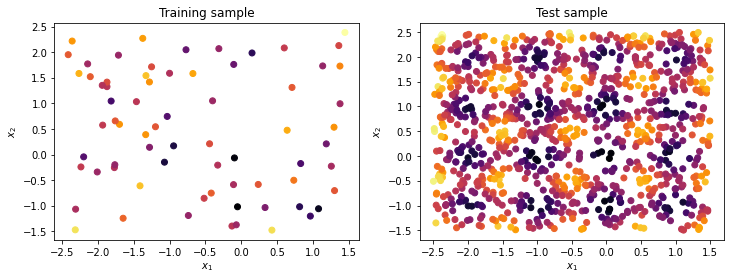

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(X_train[0], X_train[1], c=y_train, cmap="inferno")
plt.title("Training sample")
plt.ylabel("$x_2$")
plt.xlabel("$x_1$")
plt.subplot(122)
plt.scatter(X_test[0], X_test[1], c=y_test, cmap="inferno")
plt.title("Test sample")
plt.ylabel("$x_2$")
plt.xlabel("$x_1$")
plt.show()

Train Default Gaussian Process Model

In [6]:
def obj_func(func, **args):
    return lambda x: func(x, **args)[0]

def de_func(func, bounds, x0):
    res = differential_evolution(obj_func(func), bounds, x0=x0)
    return res.x, res.fun

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.optimize import differential_evolution
# from scipy.optimize import 
from sklearn.gaussian_process.kernels import RBF
gpr = GaussianProcessRegressor(optimizer=lambda func, thetas, bounds: de_func(func, bounds, x0=thetas), kernel=RBF(length_scale=np.ones(n_dims)))
gpr.fit(X_train.T, y_train)
y_pred = gpr.predict(X_train.T)

In [9]:
gpr.kernel_.theta

array([-1.03919721, -1.09691988])

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
print(f'''Training Errors:
          Log Marginal Likelihood: {gpr.log_marginal_likelihood_value_}
          Mean Squared Error: {mean_squared_error(y_train, y_pred)}
          R2 Score: {r2_score(y_train, y_pred)}
''')

Training Errors:
          Log Marginal Likelihood: -34146.92764071291
          Mean Squared Error: 9.980415020821149e-17
          R2 Score: 1.0



In [11]:
y_pred_test = gpr.predict(X_test.T)
print(f'''Test Errors:
          Log Marginal Likelihood: {gpr.log_marginal_likelihood_value_}
          Mean Squared Error: {mean_squared_error(y_test, y_pred_test)}
          R2 Score: {r2_score(y_test, y_pred_test)}
''')

Test Errors:
          Log Marginal Likelihood: -34146.92764071291
          Mean Squared Error: 143.33440763568296
          R2 Score: -0.35446732303333883



In [12]:
gpr.log_marginal_likelihood([1.69])

-20214461058158.336

In [13]:
gpr.kernel_.theta

array([-1.06992398])

In [11]:
m = np.arange(-2.5,1.5,0.01)
p = np.arange(-1.5,2.5,0.01)
X = np.array(np.meshgrid(m, p))
Y = np.zeros((400,400))
for i in range(len(X.T)):
    Y[i] = gpr.predict(X.T[i])

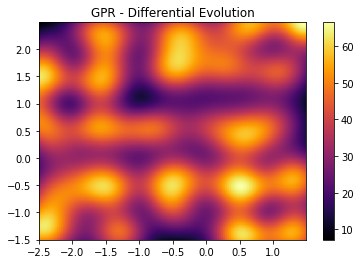

In [12]:
plt.pcolormesh(np.array(np.meshgrid(m, p))[0], np.array(np.meshgrid(m, p))[1], Y, cmap="inferno")
plt.colorbar()
plt.title("GPR - Differential Evolution")
plt.show()

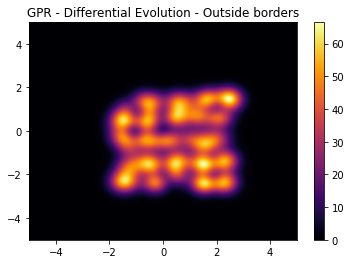

In [13]:
m = np.arange(-5,5,0.01)
p = np.arange(-5,5,0.01)
X_ = np.array(np.meshgrid(m, p))
Y = np.zeros((len(m),len(p)))
for i in range(len(X_.T)):
    Y[i] = gpr.predict(X_.T[i])

plt.pcolormesh(np.array(np.meshgrid(m, p))[0], np.array(np.meshgrid(m, p))[1], Y, cmap="inferno")
plt.colorbar()
plt.title("GPR - Differential Evolution - Outside borders")
plt.show()

In [14]:
gpr.kernel_.theta

array([-1.07051655])

Groundtruth

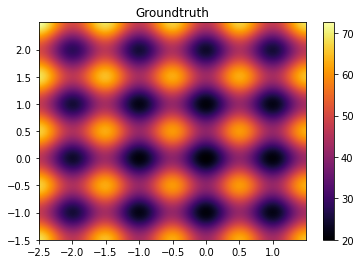

In [15]:
m = np.arange(-2.5,1.5,0.001)
p = np.arange(-1.5,2.5,0.001)
visualize_meshgrid(m, p, target_func, title='Groundtruth')

In [16]:
def random_search(g,alpha_choice,max_its,w,num_samples):
    # run random search
    weight_history = []         # container for weight history
    cost_history = []           # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):        
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
            
        # record weights and cost evaluation
        weight_history.append(w)
        cost_history.append(g(w))
        
        # construct set of random unit directions
        directions = np.random.randn(num_samples,np.size(w))
        norms = np.sqrt(np.sum(directions*directions,axis = 1))[:,np.newaxis]
        directions = directions/norms   
        
        ### pick best descent direction
        # compute all new candidate points
        w_candidates = w + alpha*directions
        
        # evaluate all candidates
        evals = np.array([g(w_val) for w_val in w_candidates])

        # if we find a real descent direction take the step in its direction
        ind = np.argmin(evals)
        if g(w_candidates[ind]) < g(w):
            # pluck out best descent direction
            d = directions[ind,:]
        
            # take step
            w = w + alpha*d
        
    # record weights and cost evaluation
    weight_history.append(w)
    cost_history.append(g(w))
    return weight_history,cost_history

In [17]:
gpr = GaussianProcessRegressor(optimizer=random_search, kernel=RBF())
gpr.fit(X_train.T, y_train)
y_pred = gpr.predict(X_train.T)

TypeError: random_search() got an unexpected keyword argument 'bounds'

In [ ]:
print(f'''Training Errors:
          Log Marginal Likelihood: {gpr.log_marginal_likelihood_value_}
          Mean Squared Error: {mean_squared_error(y_train, y_pred)}
          R2 Score: {r2_score(y_train, y_pred)}
''')

Training Errors:
          Log Marginal Likelihood: -538550275.748918
          Mean Squared Error: 2.8955831280340573e-05
          R2 Score: 0.9999997076874468



In [ ]:
from pyswarm import pso
from pyswarms.single import GlobalBestPSO

options = {"c1": 0.5, "c2": 0.3, "w": 0.9, "k": 2, "p": 2}

bounds = ([-10,-10], [10,10])
opt_ps = GlobalBestPSO(
    n_particles=100, dimensions=2, options=options, bounds=bounds
)

gpr = GaussianProcessRegressor(optimizer=opt_ps.optimize, kernel=RBF())
gpr.fit(X_train.T, y_train)
y_pred = gpr.predict(X_train.T)
print(f'''Training Errors:
          Log Marginal Likelihood: {gpr.log_marginal_likelihood_value_}
          Mean Squared Error: {mean_squared_error(y_train, y_pred)}
          R2 Score: {r2_score(y_train, y_pred)}
''')

2022-07-21 18:16:14,266 - pyswarms.single.global_best - INFO - Optimize for [0.] iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 2, 'p': 2}


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
x_max

array([10., 10.])